In [1]:
import pickle
from matplotlib import pyplot as plt
import pandas as pd
from curate_kcat import *

In [2]:
from curate_kcat_light_goslim_asc_step1 import *
results02 = pickle.load(open('../Results/smc_abc_light_step_02.pkl','rb'))

results03 = pickle.load(open('../Results/smc_abc_light_step_03.pkl','rb'))

In [3]:
[val02,val03] = pickle.load(open('../Results/validation_growth_on_unused_conditions.pkl','rb'))
[val_prior02,val_prior03] = pickle.load(open('../Results/validation_growth_on_unused_conditions_prior.pkl','rb'))

### 1. Training and validation results

In [4]:
def collect_data(res):
    res_with = {}
    res_without = {}
    
    for p in res:
        for k,lst in p.items():
            lst = lst.copy()
            for i in range(len(lst)):
                if lst[i]<0: lst[i] = 0
            res_with[k] = res_with.get(k,[]) + [lst[0]]
            try:res_without[k] = res_without.get(k,[]) + [lst[1]]
            except: None
                
    return res_with,res_without

In [81]:
def plot_dot_bar(data,positions,label=None,color=None):
    data = np.array(data)
    data[data==-1] = 0
    means = np.mean(data,axis=1)
    
    plt.bar(positions,means,label=label,color=color)
    rep_x = []
    for item in positions: rep_x += [item for _ in range(data.shape[1])]
    p_rep_x = rep_x + np.random.normal(scale=0.1,size=len(rep_x))
    
    plt.scatter(p_rep_x,data.flatten(),s=2,zorder=3,color='gray')
    

In [27]:
# training data 
res_train_02,_ = collect_data(results02.simulated_data)
res_train_03,_ = collect_data(results03.simulated_data)

res_train_prior_02,_ = collect_data(results02.simulated_data_t0)
res_train_prior_03,_ = collect_data(results03.simulated_data_t0)

In [28]:
train_ids = list(res_train_02.keys())
val_ids = list(val02.keys())
train_ids,val_ids

(['Fermentation-9h', 'Fermentation-19h', 'Fermentation-30h', 'NACL60', 'HN'],
 ['NACL20', 'NACL100', 'MU'])

In [31]:
prior_data02 = [res_train_prior_02[item] for item in train_ids] + [val_prior02[item] for item in val_ids]
prior_data03 = [res_train_prior_03[item] for item in train_ids] + [val_prior03[item] for item in val_ids]
post_data02 = [res_train_02[item] for item in train_ids] + [val02[item] for item in val_ids]
post_data03 = [res_train_03[item] for item in train_ids] + [val03[item] for item in val_ids]

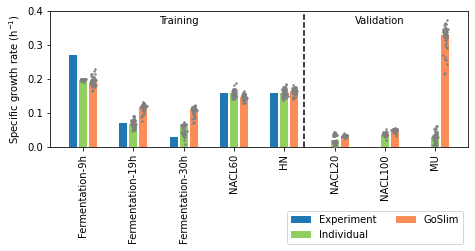

In [89]:
pos = np.arange(len(post_data03))*5
plt.figure(figsize=(7.5,2.5))
#plot_dot_bar(prior_data02,positions=pos,label='Prior02')
#plot_dot_bar(prior_data03,positions=pos+1,label='Prior03')
exp_data = [results02.datasets['dfpheno'].loc[item,'SpecificGrowthRate'] for item in train_ids]
plt.bar(pos[:len(exp_data)],exp_data,label='Experiment')
plot_dot_bar(post_data03,positions=pos+1,label='Individual',color='#91cf60')
plot_dot_bar(post_data02,positions=pos+2,label='GoSlim',color='#fc8d59')

ylim=(0,0.4)
plt.plot([pos[4]+3]*2,ylim,'k--')

plt.ylim(ylim)
plt.xticks(pos+1,train_ids+val_ids,rotation=90)
plt.legend(bbox_to_anchor=(1.0,-0.75),ncol=2,loc='lower right')
plt.ylabel('Specific growth rate (h$^{-1}$)')

plt.text(pos[2]+0.5,0.37,'Training',ha='center',va='center')
plt.text(pos[6]+0.5,0.37,'Validation',ha='center',va='center')
plt.savefig('../figures/train_validation_02_03.pdf',bbox_inches='tight')
plt.show()

In [3]:
def extract_mean_var(results):
    def _format_key(k):
        return '{0}__{1}'.format(k[0],k[1])
    
    prior_mean, post_mean = {}, {}
    for pset in results.population_t0:
        for k,v in pset.items(): prior_mean[_format_key(k)] = prior_mean.get(_format_key(k),[]) + [np.log10(v)]
    
    for pset in results.population:
        for k,v in pset.items(): post_mean[_format_key(k)] = post_mean.get(_format_key(k),[]) + [np.log10(v)]
    
    df = pd.DataFrame()
    for k,lst in prior_mean.items():
        df.loc[k,'prior_mean'] = np.mean(lst)
        df.loc[k,'prior_std']  = np.std(lst)
        
        df.loc[k,'post_mean'] = np.mean(post_mean[k])
        df.loc[k,'post_std']  = np.std(post_mean[k])
        
    print(df.shape)
    print(df.head(n=5))
    
    
    return df # in the unit of 1/s log10-transformed

In [4]:
def extract_mean_var_inRV(results):
    def _format_key(k):
        return '{0}__{1}'.format(k[0],k[1])
    
    
    
    df = pd.DataFrame()
    for k, rv in results.prior.items():
        k = _format_key(k)
        df.loc[k,'prior_mean'] = rv.loc
        df.loc[k,'prior_std']  = rv.scale
        
    for k, rv in results.posterior.items():
        k = _format_key(k)
        df.loc[k,'post_mean'] = rv.loc
        df.loc[k,'post_std']  = rv.scale
        
    print(df.shape)
    print(df.head(n=5))
    
    
    return df # in the unit of 1/s log10-transformed

def extract_mean_var2(results):
    def _format_key(k):
        return '{0}__{1}'.format(k[0],k[1])
    
    prior_mean, post_mean = {}, {}
    for pset in results.population_t0_kcats:
        for k,v in pset.items(): prior_mean[_format_key(k)] = prior_mean.get(_format_key(k),[]) + [np.log10(v)]
        # v is in the unit of 1/h
        
    for pset in results.population_kcats:
        for k,v in pset.items(): post_mean[_format_key(k)] = post_mean.get(_format_key(k),[]) + [np.log10(v)]
    
    df = pd.DataFrame()
    for k,lst in prior_mean.items():
        df.loc[k,'prior_mean'] = 10**np.mean(lst)/3600
        df.loc[k,'prior_std'] = 10**np.std(lst)/3600
        
        df.loc[k,'post_mean'] = 10**np.mean(post_mean[k])/3600
        df.loc[k,'post_std'] = 10**np.std(post_mean[k])/3600
        
    print(df.shape)
    print(df.head(n=5))
    
    
    return df # in the unit of 1/s

In [5]:
def plot_mean_dist_comp(df):
    
    plt.figure(figsize=(3.5,3))
    plt.hist(df['prior_mean'],50,label='prior',alpha=0.5)
    plt.hist(df['post_mean'],50,label='post',alpha=0.5)
    
    plt.xlabel('log10($k_{cat}$) (1/h)')
    plt.ylabel('Count')
    plt.title('mean')
    plt.legend()
    
    plt.tight_layout() 
    plt.show()
    
    plt.figure(figsize=(3.5,3))
    plt.hist(df['prior_std'],50,label='prior',alpha=0.5)
    plt.hist(df['post_std'],50,label='post',alpha=0.5)
    plt.title('std')
    
    plt.xlabel('log10($k_{cat}$) (1/h)')
    plt.ylabel('Count')
    
    plt.legend()
    
    plt.tight_layout() 
    plt.show()
    
    

In [6]:
def plot_mean_scatter_comp(df):
    
    def _scatter_plot(prior,post,lim,title):
        
        plt.figure(figsize=(3.5,3))
        plt.scatter(prior,post,zorder=1,edgecolor='#5ab4ac',
            facecolor='none',
            s=20,
            alpha=0.8)
    
        plt.xlabel('Prior log10($k_{cat}$) (1/h)')
        plt.ylabel('Posterior log10($k_{cat}$) (1/h)')

        #lim = [-7,5]
        plt.plot(lim,lim,zorder=0,color='k')

        plt.xlim(lim)
        plt.ylim(lim)
        plt.title(title)
        plt.tight_layout() 
        plt.show()
    
    
    
    _scatter_plot(df['prior_mean'],df['post_mean'],[0,9],'mean')
    _scatter_plot(df['prior_std'],df['post_std'],[0,7],'std')
   

In [7]:
def visualize(results):
    dfmstd = extract_mean_var_inRV(results)
    plot_mean_dist_comp(dfmstd)
    plot_mean_scatter_comp(dfmstd)

(2497, 4)
                                               prior_mean  prior_std  \
RXN0-7230No1__prot_TD01GL002123_c                4.725021   4.842504   
CHD-RXNNo1__prot_TD01GL002123_c                  4.725021   4.842504   
RXN-6021No1__prot_TD01GL002123_c                 5.305547   4.471942   
CHD-RXN_REVNo1__prot_TD01GL002123_c              4.725021   4.842504   
DEOXYRIBOSE-P-ALD-RXNNo1__prot_TD01GL000926_c    5.439844   4.290950   

                                               post_mean  post_std  
RXN0-7230No1__prot_TD01GL002123_c               4.258953  0.763642  
CHD-RXNNo1__prot_TD01GL002123_c                 3.917714  0.860314  
RXN-6021No1__prot_TD01GL002123_c                6.168649  1.433129  
CHD-RXN_REVNo1__prot_TD01GL002123_c             3.376301  0.936485  
DEOXYRIBOSE-P-ALD-RXNNo1__prot_TD01GL000926_c   4.890233  0.523267  


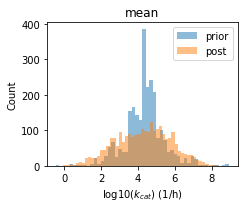

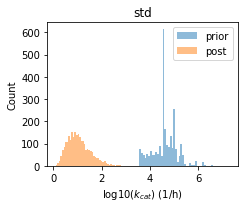

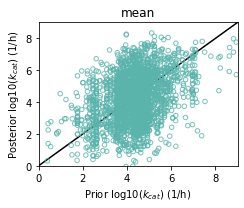

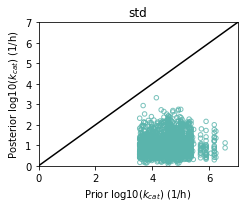

In [8]:
visualize(results1)

(2497, 4)
                                               prior_mean  prior_std  \
RXN-6021No1__prot_TD01GL002123_c                 5.305547   4.471942   
RXN0-7230No1__prot_TD01GL002123_c                4.725021   4.842504   
CHD-RXNNo1__prot_TD01GL002123_c                  4.725021   4.842504   
CHD-RXN_REVNo1__prot_TD01GL002123_c              4.725021   4.842504   
DEOXYRIBOSE-P-ALD-RXNNo1__prot_TD01GL000926_c    5.439844   4.290950   

                                               post_mean  post_std  
RXN-6021No1__prot_TD01GL002123_c                3.677867  0.561823  
RXN0-7230No1__prot_TD01GL002123_c               3.037731  1.472474  
CHD-RXNNo1__prot_TD01GL002123_c                 2.075813  0.625598  
CHD-RXN_REVNo1__prot_TD01GL002123_c             2.896047  1.362263  
DEOXYRIBOSE-P-ALD-RXNNo1__prot_TD01GL000926_c   6.371746  0.469510  


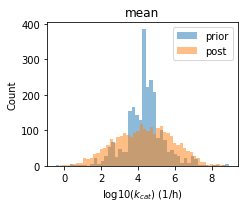

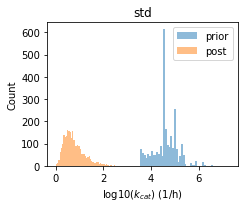

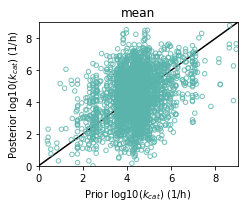

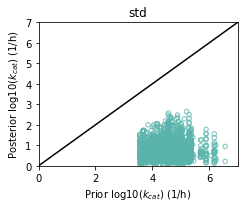

In [9]:
visualize(results2)